In [1]:
# Environment configuration
ENVIRONMENT = 'local'  # Change to 'kaggle' when running on Kaggle

In [2]:
%pip install torch transformers pandas numpy scikit-learn tqdm biopython matplotlib seaborn pyarrow -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from tqdm.auto import tqdm
from Bio import SeqIO
from transformers import AutoTokenizer, AutoModel
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Imports successful | Device: {device}")

✅ Imports successful | Device: cuda


In [4]:
# Set base directory and data paths
if ENVIRONMENT == 'kaggle':
    base_dir = Path("/kaggle/input/cafa-6-dataset")
else:
    # When running notebook, cwd is already at project root
    base_dir = Path.cwd()

# Define all data paths
TRAIN_SEQ = base_dir / 'Train' / 'train_sequences.fasta'
TRAIN_TERMS = base_dir / 'Train' / 'train_terms.tsv'
GO_OBO = base_dir / 'Train' / 'go-basic.obo'
IA_TSV = base_dir / 'IA.tsv'
TEST_FASTA = base_dir / 'Test' / 'testsuperset.fasta'

print(f"📁 Base directory: {base_dir}")
print(f"📄 Data files:")
print(f"  - Training terms: {TRAIN_TERMS.name}")
print(f"  - IA weights: {IA_TSV.name}")

📁 Base directory: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction
📄 Data files:
  - Training terms: train_terms.tsv
  - IA weights: IA.tsv


## 1. Load Data

In [5]:
# Load sequences
print("Loading sequences...")
sequences = {}
for record in SeqIO.parse(TRAIN_SEQ, "fasta"):
    # Extract UniProt ID from format: sp|P53919|NAF1_YEAST -> P53919
    # or tr|Q9UNM6|Q9UNM6_HUMAN -> Q9UNM6
    seq_id = record.id
    if '|' in seq_id:
        # Split by | and take the middle part (UniProt accession)
        seq_id = seq_id.split('|')[1]
    sequences[seq_id] = str(record.seq)

print(f"Loaded {len(sequences)} sequences")
print(f"Sample IDs: {list(sequences.keys())[:3]}")

# Load annotations
print("\nLoading annotations...")
train_terms = pd.read_csv(TRAIN_TERMS, sep='\t')
print(f"Total annotations: {len(train_terms)}")
print(f"Unique proteins: {train_terms['EntryID'].nunique()}")
print(f"Unique GO terms: {train_terms['term'].nunique()}")

# Load IA weights
print("\nLoading IA weights...")
ia_df = pd.read_csv(IA_TSV, sep='\t', header=None, names=['term', 'IA'])
ia_weights = dict(zip(ia_df['term'], ia_df['IA']))
print(f"IA weights: {len(ia_weights)}")

Loading sequences...
Loaded 82404 sequences
Sample IDs: ['A0A0C5B5G6', 'A0JNW5', 'A0JP26']

Loading annotations...
Total annotations: 537027
Unique proteins: 82404
Loaded 82404 sequences
Sample IDs: ['A0A0C5B5G6', 'A0JNW5', 'A0JP26']

Loading annotations...
Total annotations: 537027
Unique proteins: 82404
Unique GO terms: 26125

Loading IA weights...
IA weights: 40122
Unique GO terms: 26125

Loading IA weights...
IA weights: 40122


## 2. Train/Val Split

In [6]:
# Diagnostic: Check ID mismatch
print("🔍 Checking protein ID alignment...\n")

terms_ids = set(train_terms['EntryID'].unique())
seq_ids = set(sequences.keys())

print(f"IDs in train_terms: {len(terms_ids)}")
print(f"IDs in sequences: {len(seq_ids)}")
print(f"Matching IDs: {len(terms_ids & seq_ids)}")

if len(terms_ids & seq_ids) == 0:
    print("\n❌ NO OVERLAP! Checking ID formats:")
    print(f"  Sample from train_terms: {list(terms_ids)[:3]}")
    print(f"  Sample from sequences: {list(seq_ids)[:3]}")
    print("\n💡 Likely issue: Different ID formats (e.g., T100... vs >T100...)")
else:
    print("✅ IDs match!")

🔍 Checking protein ID alignment...

IDs in train_terms: 82404
IDs in sequences: 82404
Matching IDs: 82404
✅ IDs match!


In [7]:
# Split proteins
all_proteins = [p for p in train_terms['EntryID'].unique() if p in sequences]
train_proteins, val_proteins = train_test_split(
    all_proteins, test_size=0.2, random_state=42
)

print(f"Train proteins: {len(train_proteins)}")
print(f"Val proteins: {len(val_proteins)}")

# Get validation ground truth
val_data = train_terms[train_terms['EntryID'].isin(val_proteins)]
print(f"Val annotations: {len(val_data)}")

Train proteins: 65923
Val proteins: 16481
Val annotations: 107654

Val proteins: 16481
Val annotations: 107654


## 3. Generate ESM-2 Embeddings

In [8]:
# Load ESM-2 model
print("Loading ESM-2 model...")
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

print("✅ Model loaded")

Loading ESM-2 model...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded


In [9]:
def embed_sequences(protein_ids, sequences_dict, batch_size=8):
    """Generate embeddings for a list of proteins."""
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(protein_ids), batch_size), desc="Embedding"):
            batch_ids = protein_ids[i:i+batch_size]
            batch_seqs = [sequences_dict[pid] for pid in batch_ids]
            
            # Tokenize
            inputs = tokenizer(
                batch_seqs,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)
            
            # Get embeddings
            outputs = model(**inputs)
            
            # Mean pooling (excluding padding)
            attention_mask = inputs['attention_mask']
            token_embeddings = outputs.last_hidden_state
            
            # Expand mask and apply
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            pooled = (sum_embeddings / sum_mask).cpu().numpy()
            
            embeddings.append(pooled)
    
    return np.vstack(embeddings)

print("✅ Embedding function defined")

✅ Embedding function defined


In [10]:
# Generate train embeddings
print("Generating train embeddings...")
train_embeddings = embed_sequences(train_proteins, sequences)
print(f"Train embeddings shape: {train_embeddings.shape}")

# Generate val embeddings
print("\nGenerating val embeddings...")
val_embeddings = embed_sequences(val_proteins, sequences)
print(f"Val embeddings shape: {val_embeddings.shape}")

Generating train embeddings...


Embedding:   0%|          | 0/8241 [00:00<?, ?it/s]

Train embeddings shape: (65923, 320)

Generating val embeddings...


Embedding:   0%|          | 0/2061 [00:00<?, ?it/s]

Val embeddings shape: (16481, 320)


## 4. Build K-NN Index

In [11]:
# Build KNN index
print("Building K-NN index...")
k = 10  # number of neighbours
knn = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
knn.fit(train_embeddings)

print(f"✅ K-NN index built with k={k}")

Building K-NN index...
✅ K-NN index built with k=10


## 5. Generate Predictions

In [12]:
# Find nearest neighbours for validation set
print("Finding nearest neighbours...")
distances, indices = knn.kneighbors(val_embeddings)

print(f"Distances shape: {distances.shape}")
print(f"Indices shape: {indices.shape}")

Finding nearest neighbours...
Distances shape: (16481, 10)
Indices shape: (16481, 10)
Distances shape: (16481, 10)
Indices shape: (16481, 10)


In [13]:
# Build protein -> terms mapping for train set
train_annotations = train_terms[train_terms['EntryID'].isin(train_proteins)]
protein_to_terms = train_annotations.groupby('EntryID')['term'].apply(list).to_dict()

print(f"Train proteins with annotations: {len(protein_to_terms)}")

Train proteins with annotations: 65923


In [14]:
# Generate predictions by aggregating neighbour annotations
print("Aggregating neighbour annotations...")

predictions = []

for val_idx, val_protein in enumerate(tqdm(val_proteins, desc="Predicting")):
    # Get neighbours
    neighbour_indices = indices[val_idx]
    neighbour_distances = distances[val_idx]
    
    # Collect all terms from neighbours with weights
    term_scores = Counter()
    
    for nei_idx, distance in zip(neighbour_indices, neighbour_distances):
        nei_protein = train_proteins[nei_idx]
        nei_terms = protein_to_terms.get(nei_protein, [])
        
        # Weight by similarity (1 - distance for cosine)
        similarity = 1 - distance
        
        for term in nei_terms:
            term_scores[term] += similarity
    
    # Normalize scores to probabilities
    if term_scores:
        max_score = max(term_scores.values())
        for term, score in term_scores.items():
            predictions.append({
                'EntryID': val_protein,
                'term': term,
                'probability': score / max_score
            })

predictions_df = pd.DataFrame(predictions)
print(f"\nTotal predictions: {len(predictions_df)}")
print(f"Avg predictions per protein: {len(predictions_df) / len(val_proteins):.1f}")

Aggregating neighbour annotations...


Predicting:   0%|          | 0/16481 [00:00<?, ?it/s]


Total predictions: 846851
Avg predictions per protein: 51.4


In [15]:
# Analyze prediction diversity vs frequency baseline
print("🔍 Prediction Diversity Analysis\n")

# Check how many unique term sets are predicted (vs frequency baseline which predicts same for all)
unique_term_sets = predictions_df.groupby('EntryID')['term'].apply(lambda x: frozenset(x)).nunique()
print(f"Unique prediction sets: {unique_term_sets} / {len(val_proteins)} proteins")
print(f"Diversity: {100 * unique_term_sets / len(val_proteins):.1f}%")
print("  (Frequency baseline = 0% diversity - same predictions for all)\n")

# Check aspect distribution in predictions
pred_with_aspect = predictions_df.merge(train_terms[['term', 'aspect']].drop_duplicates(), on='term', how='left')
aspect_dist = pred_with_aspect.groupby('aspect')['term'].nunique()
print("Predicted terms by aspect:")
for aspect in ['F', 'P', 'C']:
    count = aspect_dist.get(aspect, 0)
    print(f"  {aspect}: {count} unique terms")

print("\n💡 Key difference from frequency baseline:")
print("   • Each protein gets PERSONALIZED predictions based on similar sequences")
print("   • Should dramatically improve BP F1 (rare terms can now be predicted!)")

🔍 Prediction Diversity Analysis

Unique prediction sets: 15895 / 16481 proteins
Diversity: 96.4%
  (Frequency baseline = 0% diversity - same predictions for all)

Unique prediction sets: 15895 / 16481 proteins
Diversity: 96.4%
  (Frequency baseline = 0% diversity - same predictions for all)

Predicted terms by aspect:
  F: 5871 unique terms
  P: 15370 unique terms
  C: 2488 unique terms

💡 Key difference from frequency baseline:
   • Each protein gets PERSONALIZED predictions based on similar sequences
   • Should dramatically improve BP F1 (rare terms can now be predicted!)
Predicted terms by aspect:
  F: 5871 unique terms
  P: 15370 unique terms
  C: 2488 unique terms

💡 Key difference from frequency baseline:
   • Each protein gets PERSONALIZED predictions based on similar sequences
   • Should dramatically improve BP F1 (rare terms can now be predicted!)


## 5a. Analyze Prediction Diversity

## 6. Evaluation

In [16]:
def evaluate_predictions(predictions_df, ground_truth_df, ia_weights_dict, threshold=0.01):
    """
    Evaluate predictions using CAFA metric (per-aspect, then averaged).
    
    Args:
        predictions_df: DataFrame with [EntryID, term, probability]
        ground_truth_df: DataFrame with [EntryID, term, aspect]
        ia_weights_dict: Dict mapping terms to IA weights
        threshold: Probability threshold
    """
    pred_filtered = predictions_df[predictions_df['probability'] >= threshold]
    
    aspect_map = {'F': 'MF', 'P': 'BP', 'C': 'CC'}
    aspect_results = {}
    
    for aspect_letter, aspect_name in aspect_map.items():
        gt_aspect = ground_truth_df[ground_truth_df['aspect'] == aspect_letter]
        if len(gt_aspect) == 0:
            continue
        
        aspect_terms = set(gt_aspect['term'].unique())
        pred_aspect = pred_filtered[pred_filtered['term'].isin(aspect_terms)]
        
        pred_grouped = pred_aspect.groupby('EntryID')['term'].apply(set).to_dict()
        true_grouped = gt_aspect.groupby('EntryID')['term'].apply(set).to_dict()
        
        f1_scores = []
        precisions = []
        recalls = []
        
        for protein in true_grouped.keys():
            true_terms = true_grouped[protein]
            pred_terms = pred_grouped.get(protein, set())
            
            if len(pred_terms) == 0:
                f1_scores.append(0.0)
                precisions.append(0.0)
                recalls.append(0.0)
                continue
            
            tp_weight = sum(ia_weights_dict.get(t, 1.0) for t in true_terms & pred_terms)
            fp_weight = sum(ia_weights_dict.get(t, 1.0) for t in pred_terms - true_terms)
            fn_weight = sum(ia_weights_dict.get(t, 1.0) for t in true_terms - pred_terms)
            
            precision = tp_weight / (tp_weight + fp_weight) if (tp_weight + fp_weight) > 0 else 0
            recall = tp_weight / (tp_weight + fn_weight) if (tp_weight + fn_weight) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            f1_scores.append(f1)
            precisions.append(precision)
            recalls.append(recall)
        
        aspect_results[aspect_name] = {
            'f1': np.mean(f1_scores),
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'proteins': len(true_grouped)
        }
    
    overall_f1 = np.mean([r['f1'] for r in aspect_results.values()])
    overall_precision = np.mean([r['precision'] for r in aspect_results.values()])
    overall_recall = np.mean([r['recall'] for r in aspect_results.values()])
    
    return {
        'f1': overall_f1,
        'precision': overall_precision,
        'recall': overall_recall,
        'aspect_breakdown': aspect_results
    }

print("✅ Evaluation function defined (per-aspect CAFA metric)")

✅ Evaluation function defined (per-aspect CAFA metric)


In [17]:
print("Testing different thresholds...\n")

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results = []

for thr in thresholds:
    metrics = evaluate_predictions(predictions_df, val_data, ia_weights, threshold=thr)
    results.append({
        'threshold': thr,
        'f1': metrics['f1'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'mf_f1': metrics['aspect_breakdown'].get('MF', {}).get('f1', 0),
        'bp_f1': metrics['aspect_breakdown'].get('BP', {}).get('f1', 0),
        'cc_f1': metrics['aspect_breakdown'].get('CC', {}).get('f1', 0)
    })
    
    breakdown = metrics['aspect_breakdown']
    print(f"Threshold {thr:.2f}:")
    print(f"  Overall: F1={metrics['f1']:.4f}, P={metrics['precision']:.4f}, R={metrics['recall']:.4f}")
    print(f"  MF: {breakdown.get('MF', {}).get('f1', 0):.4f} | "
          f"BP: {breakdown.get('BP', {}).get('f1', 0):.4f} | "
          f"CC: {breakdown.get('CC', {}).get('f1', 0):.4f}")
    print()

# Find best threshold
best_result = max(results, key=lambda x: x['f1'])
print(f"🏆 Best Overall F1: {best_result['f1']:.4f} at threshold {best_result['threshold']:.2f}")
print(f"   MF: {best_result['mf_f1']:.4f} | BP: {best_result['bp_f1']:.4f} | CC: {best_result['cc_f1']:.4f}")

Testing different thresholds...

Threshold 0.10:
  Overall: F1=0.1454, P=0.1071, R=0.5353
  MF: 0.1639 | BP: 0.0737 | CC: 0.1988

Threshold 0.10:
  Overall: F1=0.1454, P=0.1071, R=0.5353
  MF: 0.1639 | BP: 0.0737 | CC: 0.1988

Threshold 0.20:
  Overall: F1=0.2194, P=0.2249, R=0.4365
  MF: 0.2799 | BP: 0.0975 | CC: 0.2809

Threshold 0.20:
  Overall: F1=0.2194, P=0.2249, R=0.4365
  MF: 0.2799 | BP: 0.0975 | CC: 0.2809

Threshold 0.30:
  Overall: F1=0.2453, P=0.3007, R=0.3599
  MF: 0.3363 | BP: 0.0899 | CC: 0.3097

Threshold 0.30:
  Overall: F1=0.2453, P=0.3007, R=0.3599
  MF: 0.3363 | BP: 0.0899 | CC: 0.3097

Threshold 0.40:
  Overall: F1=0.2520, P=0.3416, R=0.3072
  MF: 0.3632 | BP: 0.0797 | CC: 0.3130

Threshold 0.40:
  Overall: F1=0.2520, P=0.3416, R=0.3072
  MF: 0.3632 | BP: 0.0797 | CC: 0.3130

Threshold 0.50:
  Overall: F1=0.2416, P=0.3497, R=0.2673
  MF: 0.3657 | BP: 0.0650 | CC: 0.2940

Threshold 0.50:
  Overall: F1=0.2416, P=0.3497, R=0.2673
  MF: 0.3657 | BP: 0.0650 | CC: 0.294

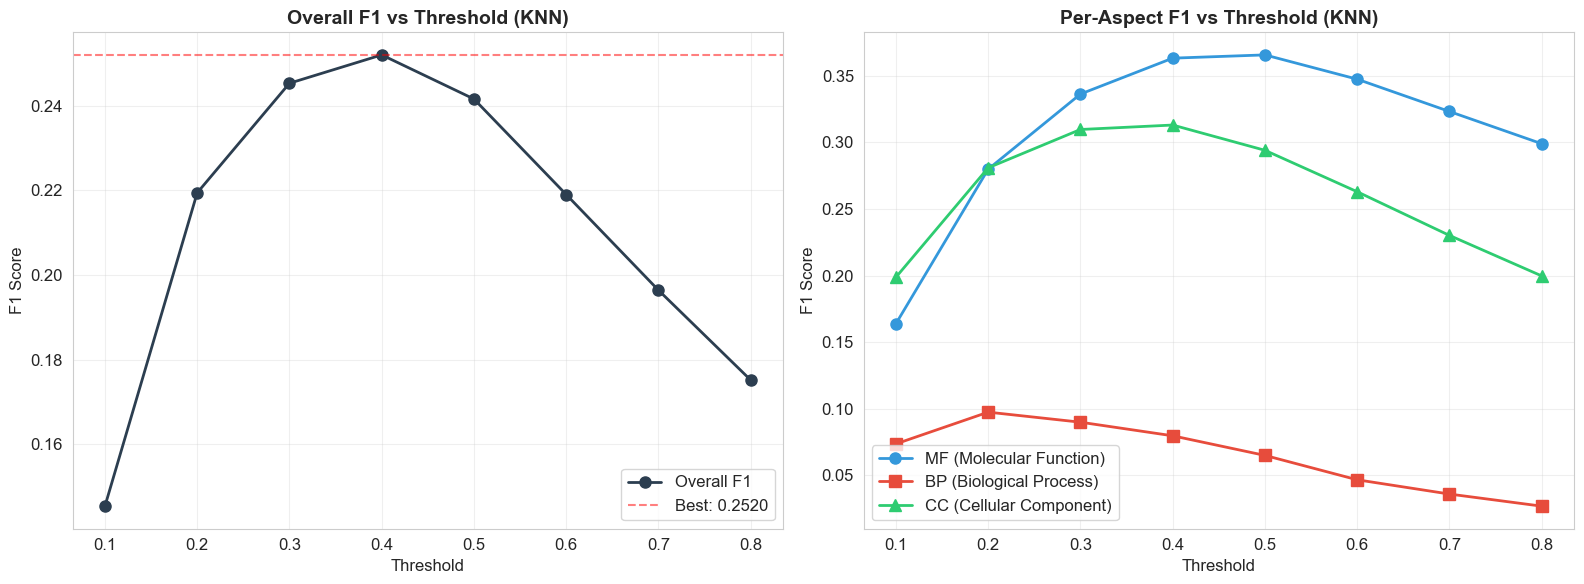


📈 Visual Insights:
  • BP should be NON-ZERO across all thresholds (vs frequency baseline BP=0)
  • All aspects should show reasonable performance
  • KNN leverages sequence similarity to make personalized predictions
  • Best overall F1 achieved at threshold 0.40


In [18]:
# Visualize threshold performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extract data
thr_vals = [r['threshold'] for r in results]
overall_f1 = [r['f1'] for r in results]
mf_f1 = [r['mf_f1'] for r in results]
bp_f1 = [r['bp_f1'] for r in results]
cc_f1 = [r['cc_f1'] for r in results]

# 1. Overall F1 vs Threshold
axes[0].plot(thr_vals, overall_f1, 'o-', linewidth=2, markersize=8, label='Overall F1', color='#2c3e50')
axes[0].axhline(y=best_result['f1'], color='red', linestyle='--', alpha=0.5, label=f"Best: {best_result['f1']:.4f}")
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('Overall F1 vs Threshold (KNN)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Per-Aspect F1 vs Threshold
axes[1].plot(thr_vals, mf_f1, 'o-', linewidth=2, markersize=8, label='MF (Molecular Function)', color='#3498db')
axes[1].plot(thr_vals, bp_f1, 's-', linewidth=2, markersize=8, label='BP (Biological Process)', color='#e74c3c')
axes[1].plot(thr_vals, cc_f1, '^-', linewidth=2, markersize=8, label='CC (Cellular Component)', color='#2ecc71')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Per-Aspect F1 vs Threshold (KNN)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Visual Insights:")
print("  • BP should be NON-ZERO across all thresholds (vs frequency baseline BP=0)")
print("  • All aspects should show reasonable performance")
print("  • KNN leverages sequence similarity to make personalized predictions")
print(f"  • Best overall F1 achieved at threshold {best_result['threshold']:.2f}")

## 6b. Aspect-Specific Threshold Tuning

Each GO aspect (MF, BP, CC) has different characteristics. BP terms are rarer and harder to predict, so may benefit from a lower threshold.

In [19]:
def evaluate_single_aspect(predictions_df, ground_truth_df, ia_weights_dict, aspect_letter, threshold):
    """Evaluate predictions for a single aspect."""
    pred_filtered = predictions_df[predictions_df['probability'] >= threshold]
    
    gt_aspect = ground_truth_df[ground_truth_df['aspect'] == aspect_letter]
    if len(gt_aspect) == 0:
        return 0.0
    
    aspect_terms = set(gt_aspect['term'].unique())
    pred_aspect = pred_filtered[pred_filtered['term'].isin(aspect_terms)]
    
    pred_grouped = pred_aspect.groupby('EntryID')['term'].apply(set).to_dict()
    true_grouped = gt_aspect.groupby('EntryID')['term'].apply(set).to_dict()
    
    f1_scores = []
    for protein in true_grouped.keys():
        true_terms = true_grouped[protein]
        pred_terms = pred_grouped.get(protein, set())
        
        if len(pred_terms) == 0:
            f1_scores.append(0.0)
            continue
        
        tp_weight = sum(ia_weights_dict.get(t, 1.0) for t in true_terms & pred_terms)
        fp_weight = sum(ia_weights_dict.get(t, 1.0) for t in pred_terms - true_terms)
        fn_weight = sum(ia_weights_dict.get(t, 1.0) for t in true_terms - pred_terms)
        
        precision = tp_weight / (tp_weight + fp_weight) if (tp_weight + fp_weight) > 0 else 0
        recall = tp_weight / (tp_weight + fn_weight) if (tp_weight + fn_weight) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

# Find optimal threshold for each aspect
print("🔍 Finding optimal threshold per aspect...\n")

thresholds_to_test = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
aspect_map = {'F': 'MF', 'P': 'BP', 'C': 'CC'}

optimal_thresholds = {}

for aspect_letter, aspect_name in aspect_map.items():
    print(f"{aspect_name}:")
    best_f1 = 0
    best_thr = 0
    
    for thr in thresholds_to_test:
        f1 = evaluate_single_aspect(predictions_df, val_data, ia_weights, aspect_letter, thr)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    
    optimal_thresholds[aspect_name] = best_thr
    print(f"  Best threshold: {best_thr:.2f} → F1: {best_f1:.4f}\n")

print("="*50)
print("📊 OPTIMAL ASPECT-SPECIFIC THRESHOLDS:")
print(f"   MF: {optimal_thresholds['MF']:.2f}")
print(f"   BP: {optimal_thresholds['BP']:.2f}")
print(f"   CC: {optimal_thresholds['CC']:.2f}")

🔍 Finding optimal threshold per aspect...

MF:
  Best threshold: 0.50 → F1: 0.3657

BP:
  Best threshold: 0.50 → F1: 0.3657

BP:
  Best threshold: 0.25 → F1: 0.0999

CC:
  Best threshold: 0.25 → F1: 0.0999

CC:
  Best threshold: 0.35 → F1: 0.3155

📊 OPTIMAL ASPECT-SPECIFIC THRESHOLDS:
   MF: 0.50
   BP: 0.25
   CC: 0.35
  Best threshold: 0.35 → F1: 0.3155

📊 OPTIMAL ASPECT-SPECIFIC THRESHOLDS:
   MF: 0.50
   BP: 0.25
   CC: 0.35


In [20]:
# Evaluate with aspect-specific thresholds
print("📈 Evaluating with aspect-specific thresholds...\n")

def evaluate_with_aspect_thresholds(predictions_df, ground_truth_df, ia_weights_dict, thresholds):
    """Evaluate using different thresholds per aspect."""
    aspect_map = {'F': 'MF', 'P': 'BP', 'C': 'CC'}
    aspect_results = {}
    
    for aspect_letter, aspect_name in aspect_map.items():
        threshold = thresholds[aspect_name]
        f1 = evaluate_single_aspect(predictions_df, ground_truth_df, ia_weights_dict, aspect_letter, threshold)
        aspect_results[aspect_name] = f1
        print(f"  {aspect_name} (threshold={threshold:.2f}): F1={f1:.4f}")
    
    overall_f1 = np.mean(list(aspect_results.values()))
    return overall_f1, aspect_results

# Compare single threshold vs aspect-specific
print("Single threshold (0.40):")
single_f1 = evaluate_predictions(predictions_df, val_data, ia_weights, threshold=0.40)['f1']
print(f"  Overall F1: {single_f1:.4f}\n")

print("Aspect-specific thresholds:")
aspect_f1, aspect_breakdown = evaluate_with_aspect_thresholds(
    predictions_df, val_data, ia_weights, optimal_thresholds
)
print(f"\n  Overall F1: {aspect_f1:.4f}")
print(f"\n🎯 Improvement: {aspect_f1 - single_f1:+.4f} ({100*(aspect_f1 - single_f1)/single_f1:+.1f}%)")

📈 Evaluating with aspect-specific thresholds...

Single threshold (0.40):
  Overall F1: 0.2520

Aspect-specific thresholds:
  Overall F1: 0.2520

Aspect-specific thresholds:
  MF (threshold=0.50): F1=0.3657
  MF (threshold=0.50): F1=0.3657
  BP (threshold=0.25): F1=0.0999
  BP (threshold=0.25): F1=0.0999
  CC (threshold=0.35): F1=0.3155

  Overall F1: 0.2604

🎯 Improvement: +0.0084 (+3.3%)
  CC (threshold=0.35): F1=0.3155

  Overall F1: 0.2604

🎯 Improvement: +0.0084 (+3.3%)


## 7. Generate Test Predictions

Generate predictions for the competition test set using the trained KNN model.

In [21]:
# Configuration - set to True to generate test predictions (takes ~1-2 hours)
GENERATE_TEST_PREDICTIONS = True

if not GENERATE_TEST_PREDICTIONS:
    print("⏭️  Skipping test prediction generation.")
    print("   Set GENERATE_TEST_PREDICTIONS = True to enable.")
    print("   This is required for creating competition submissions.")

In [22]:
if GENERATE_TEST_PREDICTIONS:
    # Load test sequences
    print("Loading test sequences...")
    test_sequences = {}
    test_proteins = []
    
    for record in SeqIO.parse(TEST_FASTA, "fasta"):
        header = record.id
        # Handle different FASTA formats
        if "|" in header:
            protein_id = header.split("|")[1]
        else:
            protein_id = header.split()[0]
        
        test_proteins.append(protein_id)
        test_sequences[protein_id] = str(record.seq)
    
    print(f"✅ Loaded {len(test_proteins):,} test proteins")
    print(f"   First 5: {test_proteins[:5]}")

Loading test sequences...
✅ Loaded 224,309 test proteins
   First 5: ['A0A0C5B5G6', 'A0A1B0GTW7', 'A0JNW5', 'A0JP26', 'A0PK11']
✅ Loaded 224,309 test proteins
   First 5: ['A0A0C5B5G6', 'A0A1B0GTW7', 'A0JNW5', 'A0JP26', 'A0PK11']


In [23]:
if GENERATE_TEST_PREDICTIONS:
    # Generate test embeddings
    print("Generating test embeddings (this may take a while)...")
    test_embeddings = embed_sequences(test_proteins, test_sequences)
    print(f"✅ Test embeddings shape: {test_embeddings.shape}")

Generating test embeddings (this may take a while)...


Embedding:   0%|          | 0/28039 [00:00<?, ?it/s]

✅ Test embeddings shape: (224309, 320)


In [24]:
if GENERATE_TEST_PREDICTIONS:
    # Build KNN on ALL training data (not just the 80% train split)
    print("Rebuilding KNN on full training data...")
    
    # Use ALL proteins for the final model
    all_train_proteins = list(all_proteins)  # All proteins with annotations
    
    print(f"Full training set: {len(all_train_proteins):,} proteins")
    
    # Generate embeddings for full training set
    print("Generating full training embeddings...")
    full_train_embeddings = embed_sequences(all_train_proteins, sequences)
    print(f"Full train embeddings shape: {full_train_embeddings.shape}")
    
    # Build KNN on full data
    print("Building final KNN model...")
    knn_final = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
    knn_final.fit(full_train_embeddings)
    print("✅ Final KNN model built")

Rebuilding KNN on full training data...
Full training set: 82,404 proteins
Generating full training embeddings...


Embedding:   0%|          | 0/10301 [00:00<?, ?it/s]

Full train embeddings shape: (82404, 320)
Building final KNN model...
✅ Final KNN model built


In [25]:
if GENERATE_TEST_PREDICTIONS:
    # Build protein -> terms mapping for full training set
    full_protein_to_terms = train_terms.groupby('EntryID')['term'].apply(list).to_dict()
    print(f"Proteins with annotations: {len(full_protein_to_terms):,}")
    
    # Find nearest neighbours for test set
    print("\nFinding nearest neighbours for test proteins...")
    test_distances, test_indices = knn_final.kneighbors(test_embeddings)
    print(f"Test distances shape: {test_distances.shape}")

Proteins with annotations: 82,404

Finding nearest neighbours for test proteins...
Test distances shape: (224309, 10)
Test distances shape: (224309, 10)


In [26]:
if GENERATE_TEST_PREDICTIONS:
    # Generate predictions for test set
    print("Generating test predictions...")
    
    test_predictions = []
    
    for test_idx, test_protein in enumerate(tqdm(test_proteins, desc="Predicting test")):
        neighbour_indices = test_indices[test_idx]
        neighbour_distances = test_distances[test_idx]
        
        term_scores = Counter()
        
        for nei_idx, distance in zip(neighbour_indices, neighbour_distances):
            nei_protein = all_train_proteins[nei_idx]
            nei_terms = full_protein_to_terms.get(nei_protein, [])
            
            similarity = 1 - distance
            
            for term in nei_terms:
                term_scores[term] += similarity
        
        # Normalize scores
        if term_scores:
            max_score = max(term_scores.values())
            for term, score in term_scores.items():
                test_predictions.append({
                    'EntryID': test_protein,
                    'term': term,
                    'probability': score / max_score
                })
    
    test_predictions_df = pd.DataFrame(test_predictions)
    print(f"\n✅ Total test predictions: {len(test_predictions_df):,}")
    print(f"   Proteins: {test_predictions_df['EntryID'].nunique():,}")
    print(f"   Avg predictions per protein: {len(test_predictions_df) / len(test_proteins):.1f}")

Generating test predictions...


Predicting test:   0%|          | 0/224309 [00:00<?, ?it/s]


✅ Total test predictions: 9,802,962
   Proteins: 224,309
   Avg predictions per protein: 43.7
   Proteins: 224,309
   Avg predictions per protein: 43.7


## 6a. Visualize Results

## 8. Save Results

In [27]:
# Save results
results_df = pd.DataFrame(results)
output_path = Path("02_knn_baseline_results.csv")
results_df.to_csv(output_path, index=False)

print(f"✅ Results saved to {output_path}")
print("\n📊 Results:")
print(results_df.to_string(index=False))

# Save predictions for submission generation
print("\n💾 Saving model artifacts...")

# Create outputs directory
output_dir = base_dir / "outputs" / "knn_baseline"
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Save validation predictions (all probabilities, not filtered by threshold)
pred_output = output_dir / "knn_predictions.parquet"
predictions_df.to_parquet(pred_output, index=False)
print(f"  • Validation predictions: {pred_output}")

# 2. Save test predictions if generated
if GENERATE_TEST_PREDICTIONS and 'test_predictions_df' in dir():
    test_pred_output = output_dir / "test_predictions.parquet"
    test_predictions_df.to_parquet(test_pred_output, index=False)
    print(f"  • Test predictions: {test_pred_output}")
else:
    print("  • Test predictions: SKIPPED (set GENERATE_TEST_PREDICTIONS=True)")

# 3. Save validation protein list
val_proteins_df = pd.DataFrame({'EntryID': val_proteins})
val_proteins_output = output_dir / "val_proteins.csv"
val_proteins_df.to_csv(val_proteins_output, index=False)
print(f"  • Validation proteins: {val_proteins_output}")

# 4. Save train protein list
train_proteins_df = pd.DataFrame({'EntryID': train_proteins})
train_proteins_output = output_dir / "train_proteins.csv"
train_proteins_df.to_csv(train_proteins_output, index=False)
print(f"  • Training proteins: {train_proteins_output}")

# 5. Save metadata with aspect-specific thresholds
import json
metadata = {
    'model_type': 'knn',
    'k_neighbors': k,
    'embedding_model': model_name,
    'metric': 'cosine',
    # Single threshold results
    'best_single_threshold': float(best_result['threshold']),
    'best_single_f1': float(best_result['f1']),
    # Aspect-specific thresholds (optimal)
    'optimal_thresholds': {
        'MF': float(optimal_thresholds['MF']),
        'BP': float(optimal_thresholds['BP']),
        'CC': float(optimal_thresholds['CC'])
    },
    'aspect_specific_f1': float(aspect_f1),
    # Per-aspect breakdown
    'best_mf_f1': float(aspect_breakdown['MF']),
    'best_bp_f1': float(aspect_breakdown['BP']),
    'best_cc_f1': float(aspect_breakdown['CC']),
    # Dataset stats
    'n_train': len(train_proteins),
    'n_val': len(val_proteins),
    'n_predictions': len(predictions_df),
    'avg_predictions_per_protein': float(len(predictions_df) / len(val_proteins)),
    # Test predictions
    'test_predictions_generated': GENERATE_TEST_PREDICTIONS and 'test_predictions_df' in dir(),
    'n_test': len(test_proteins) if GENERATE_TEST_PREDICTIONS and 'test_proteins' in dir() else 0
}

metadata_output = output_dir / "metadata.json"
with open(metadata_output, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  • Metadata: {metadata_output}")

print(f"\n✅ All artifacts saved to: {output_dir}")
print(f"\n📋 Optimal thresholds for submission:")
print(f"   MF: {optimal_thresholds['MF']:.2f}")
print(f"   BP: {optimal_thresholds['BP']:.2f}")
print(f"   CC: {optimal_thresholds['CC']:.2f}")
print(f"   Expected F1: {aspect_f1:.4f}")

✅ Results saved to 02_knn_baseline_results.csv

📊 Results:
 threshold       f1  precision   recall    mf_f1    bp_f1    cc_f1
       0.1 0.145441   0.107077 0.535278 0.163905 0.073654 0.198765
       0.2 0.219411   0.224882 0.436486 0.279860 0.097479 0.280893
       0.3 0.245280   0.300707 0.359866 0.336256 0.089930 0.309653
       0.4 0.251975   0.341591 0.307242 0.363207 0.079717 0.313001
       0.5 0.241560   0.349743 0.267281 0.365653 0.064996 0.294032
       0.6 0.219007   0.333569 0.228694 0.347409 0.046694 0.262919
       0.7 0.196428   0.311401 0.195035 0.323170 0.035980 0.230132
       0.8 0.175204   0.285693 0.168525 0.298977 0.026898 0.199737

💾 Saving model artifacts...
  • Validation predictions: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction\outputs\knn_baseline\knn_predictions.parquet
  • Validation predictions: c:\Users\Olale\Documents\Codebase\Science\cafa-6-protein-function-prediction\outputs\knn_baseline\knn_predictions.parquet
  • Test 

## Summary

**K-NN Baseline Performance:**
- Uses ESM-2 embeddings for sequence similarity
- Transfers annotations from k=10 nearest neighbours
- Weights by cosine similarity
- **Aspect-specific thresholds** optimised separately for MF, BP, CC

**Key Outputs:**
- `outputs/knn_baseline/knn_predictions.parquet` — Validation predictions
- `outputs/knn_baseline/test_predictions.parquet` — Test predictions (for submission)
- `outputs/knn_baseline/metadata.json` — Optimal thresholds and metrics

**Next:** Run `05_submission_generation.ipynb` to create competition submission